In [1]:
#En este ejemplo vamos a coger los puntos del xml de paparazzi, vamos a optimizar el camino con un TSP y posteriormente vamos a 
#calcular las curvas de Bezier mas óptimas

In [2]:
#Cargamos los módulos que se van a necesitar
import pandas as pd

import numpy as np

import matplotlib
matplotlib.use('Qt5Agg')  # Cambia el backend a Qt5Agg para mostrar ventanas gráficas
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from pymoo.core.problem import ElementwiseProblem

from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

from matplotlib import style

#Para que el primer punto sea el inicial
from pymoo.core.repair import Repair 

#Diferentes funciones de la biblioteca para optimizar (pymoo)
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.problems.single.traveling_salesman import create_random_tsp_problem
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.operators.mutation.bitflip import BitflipMutation

In [3]:
from lxml import etree

# Ruta a tu archivo XML y DTD
xml_file = '/home/dacya-iagesbloom/Documents/paparazzi/conf/flight_plans/UCM/PRUEBA_BZ_V3_optimizar.xml'
dtd_file = '/home/dacya-iagesbloom/Documents/paparazzi/conf/flight_plans/flight_plan.dtd'

# Cargar el DTD
with open(dtd_file, 'r') as dtd_f:
    dtd = etree.DTD(dtd_f)

# Cargar el archivo XML
with open(xml_file, 'r') as xml_f:
    xml_content = xml_f.read()

# Validar el XML contra el DTD
try:
    xml_doc = etree.fromstring(xml_content)
    if dtd.validate(xml_doc):
        print("El archivo XML es válido.")
    else:
        print("El archivo XML no es válido.")
        print("Errores:")
        for error in dtd.error_log:
            print(f"Línea {error.line}: {error.message}")
except etree.XMLSyntaxError as e:
    print("Error de sintaxis XML:")
    print(e)


El archivo XML es válido.


In [4]:
#En primer lugar cargamos todos los archivos necesarios. Estos son los siguientes:
#1- Datos.txt -> Nos dice si queremos mapa o no, número de segmentos y número de puntos de control
#2- Coordenadas.txt -> Nos dice las coordenadas de los puntos de control
#3- flight_plan -> Nos da todos los datos de lo que se desea en la ruta (Puntos de paso, regiones...)

#flightplan_entrada = input("Introduce el archivo que quiere optimizar con la extensión .xml: ")
#flightplan_salida = input("Introduce como quiere llamar archivo de salida con .xml: ")

#Leemos los archivos sacados del boton de planificación
Estrategia = pd.read_csv('/home/dacya-iagesbloom/Desktop/PprzGCS/datos.txt', delimiter=':', header = None) #Datos.txt
Coordenadas = pd.read_csv('/home/dacya-iagesbloom/Desktop/PprzGCS/coordenadas.txt', delimiter=',', header=None) #Coordenadas.txt

#Carga de archivo XML
import xml.etree.ElementTree as ET
from xml.dom import minidom

tree = ET.parse('/home/dacya-iagesbloom/Documents/paparazzi/conf/flight_plans/UCM/PRUEBA_BZ_V3_optimizar.xml')
root = tree.getroot()

# Encontrar todos los waypoints
way_points = root.find('waypoints')
waypoint_list = []
unchanged_points = []

#RECORDATORIO CHECKPOINT: EL CÓDIGO ESTABA HECHO PARA DECLARAR LAS VARIABLES CON X,Y NO CON LON LAT. EL PROBLEMA VIENE DE QUE CON
#EL FLIGHT_PLAN HECHO POR MI EL SIMULADOR NO SIGUE BIEN LA RUTA. POR TANTO, ESTOY PROBANDO CON UNO QUE (A VECES) SÍ QUE HACE BIEN 
#LA RUTA. PERO HAY QUE O PASAR LON Y LAT A X E Y O QUE SEA CAPAZ DE LEER LON, LAT

# Almacenar los waypoints existentes en una lista
for waypoint in way_points.findall('waypoint'):
    name = waypoint.get('name')
    #print(name)
    if name.startswith('BZ'):
        #lat = float(waypoint.get('lat'))
        #lon = float(waypoint.get('lon'))
        x = float(waypoint.get('x'))
        y = float(waypoint.get('y'))
        #print(waypoint.get('lat'))
        #print(lon)
        #print(type(lat))
        waypoint_list.append((name, x, y))
        #waypoint_list.append((name, lat, lon))
    else:
        x = float(waypoint.get('x'))
        y = float(waypoint.get('y'))
        unchanged_points.append((name, x, y))
        print(unchanged_points)
        #waypoint_list.append((name, lon, lat))
#Limpiamos way_points
way_points.clear()

#Convertimos tanto la lista de waypoints como unchanged en una lista y las unimos
waypoints = np.array([[nombre, lat, lon] for nombre, lat, lon in waypoint_list])
unchangedpoints = np.array([[nombre, x, y] for nombre, x, y in unchanged_points])
points = np.concatenate((waypoints, unchangedpoints), axis=0)


#Definimos una matriz unicamente con las coordenadas de cada parada:
paradas = (waypoints[:,-2:])
print(paradas)
#Definimos parámetros del barco
velocidad_media = 40

[('HOME', 7.3, -26.2)]
[('HOME', 7.3, -26.2), ('STDBY', 25.9, -45.2)]
[('HOME', 7.3, -26.2), ('STDBY', 25.9, -45.2), ('ELLIPSE', 24.7, -41.1)]
[('HOME', 7.3, -26.2), ('STDBY', 25.9, -45.2), ('ELLIPSE', 24.7, -41.1), ('_N1', 60.0, 60.0)]
[('HOME', 7.3, -26.2), ('STDBY', 25.9, -45.2), ('ELLIPSE', 24.7, -41.1), ('_N1', 60.0, 60.0), ('_N2', 60.0, -60.0)]
[('HOME', 7.3, -26.2), ('STDBY', 25.9, -45.2), ('ELLIPSE', 24.7, -41.1), ('_N1', 60.0, 60.0), ('_N2', 60.0, -60.0), ('_N3', -60.0, -60.0)]
[('HOME', 7.3, -26.2), ('STDBY', 25.9, -45.2), ('ELLIPSE', 24.7, -41.1), ('_N1', 60.0, 60.0), ('_N2', 60.0, -60.0), ('_N3', -60.0, -60.0), ('_N4', -60.0, 60.0)]
[['-29.1' '20.8']
 ['-16.0' '0.4']
 ['-18.7' '43.1']]


In [5]:
#Ahora una vez tenemos los puntos vamos a añadir el algoritmo de optimización

#COSA TO DO DESPUÉS DE HABER LOGRADO UNIR EL OPTIMIZADOR CON LA RECOGIDA DE DATOS: FIJAR EL PUNTO INICIAL Y FINAL
stops=paradas

#Definimos el problema
class RUTA (ElementwiseProblem):

    def __init__(self, **kwargs):
        
        start_idx = 0  # Primer punto
        end_idx = len(waypoints)-1 # Último punto
        
        n_stops, _ = stops.shape #Aquí coge las filas (Por tanto el número de paradas)
        #n_stops=n_stops-1
        self.stops = stops
        self.D = cdist(stops, stops)
        self.start_idx = start_idx
        self.end_idx = end_idx
        super(RUTA, self).__init__(
            n_var=n_stops,
            n_obj=1,
            n_constr=2,
            xl=0,
            xu=len(stops),
            vtype=int,
            **kwargs
        )

    #Definimos las funciones de evaluación y las reestricciones
    def _evaluate(self, x, out, *args, **kwargs):
        distancia=self.get_route_length(x)
        tiempo=self.get_route_length(x)/velocidad_media
        out['F'] = [distancia]

        #Voy a poner aquí las restricciones
        #Restricciones
        
        #Max_dist=self.get_route_length(x)-250
        
        #Max_tiempo=self.get_route_length(x)/velocidad_media-250

        #x_ord=np.sort(x)
        #penalty_paradas=0
        #for i in range(len(x_ord)-1):
        #   if x_ord[i] == x_ord[i+1]:
        #       penalty_paradas=10000
        g1 = 1 if x[0] != self.start_idx else 0  # Penaliza si el primer punto no es start_idx
        g2 = 1 if x[-1] != self.end_idx else 0   # Penaliza si el último punto no es end_idx
        #out["G"]=[Max_dist, Max_tiempo + penalty_paradas]
        
        out["G"] = [g1, g2]

    #Distancia de la ruta
    def get_route_length(self, x):
        n_stops = len(x)
        dist = 0
        for k in range(n_stops - 1):
            i, j = x[k], x[k + 1]
            dist += self.D[i, j]
        return dist

#Visualización de los resultados
def visualize_3(problem, x, n, fig=None, ax=None, show=True, label=True):
    with plt.style.context('ggplot'):
        # Asegúrate de que x sea un array unidimensional
        x = np.asarray(x)  # Convierte x a un array de numpy

        if x.ndim == 1:  # Asegúrate de que es un vector
            x = x.flatten()  # Aplana el array para asegurarte de que sea 1D

        if fig is None or ax is None:
            fig, ax = plt.subplots()

        # Plot de las ciudades usando scatter plot
        ax.scatter(problem.stops[:, 0], problem.stops[:, 1], s=150)
        if label:
            # Anota las ciudades
            for i, c in enumerate(problem.stops):
                ax.annotate(str(i), xy=c, fontsize=10, ha="center", va="center", color="white")

        # Plotea la línea en el camino
        for i in range(len(x) - 1):
            current = int(x[i])  # Asegúrate de convertir a entero
            next_ = int(x[i + 1])  # Asegúrate de convertir a entero
            ax.plot(problem.stops[[current, next_], 0], problem.stops[[current, next_], 1], 'r--')

        fig.suptitle(f"Route length: {problem.get_route_length(x)} km \nRoute time: {problem.get_route_length(x) * 60 / velocidad_media} min")

        if show:
            plt.show()

In [6]:
#Para en caso en el que tengamos más de un barco hará un clustering con kmeans para clasificar las diferentes paradas
#De momento dejaremos el n_barcos fijos igual a 1 pero el algoritmo está preparado para que en algún momento se puedan añadir más
n_barcos = 1

style.use('ggplot') or plt.style.use('ggplot')

x_k, y=paradas[0], paradas[1]
X_scaled = scale(paradas)
modelo_kmeans = KMeans(n_clusters=n_barcos, n_init=25, random_state=123)
modelo_kmeans.fit(X=X_scaled)

# Clasificación con el modelo kmeans

y_predict = modelo_kmeans.predict(X=X_scaled)

#Representación
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for i in np.unique(y_predict):
    ax.scatter(
        x = X_scaled[y_predict == i, 0],
        y = X_scaled[y_predict == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Cluster {i}"
    )
    
ax.scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1], 
    c = 'black',
    s = 40,
    marker = 'o',
    label  = 'centroides'
)
ax.set_title('Clusters generados por Kmeans')
ax.legend();

0

Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

Maximum Span: 67.029
Function Evaluations: 6
[0 1 2]


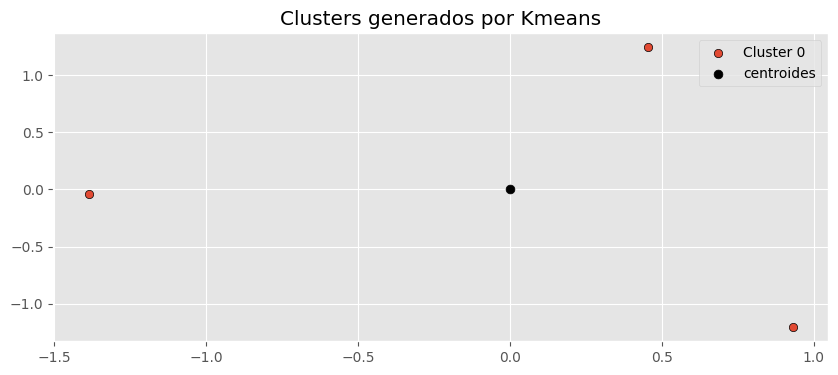

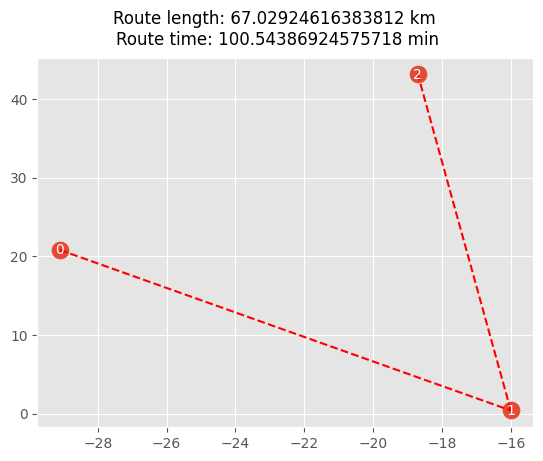

In [7]:
#Creamos un diccionario para almacenar cada ruta
rutas={}
stops=paradas.astype(float)
fitness=[]

for i in range(n_barcos):
    print(i)
    grupos_finales=np.array([stops[:,0].T, stops[:,1].T, y_predict])
    grupos_finales=grupos_finales.T
    rutas[f"ruta_{i}"]=grupos_finales[grupos_finales[:,2]==i][:,:2]
from pymoo.core.sampling import Sampling
for i in range(n_barcos):
    n_stops=len(stops)
    problem = RUTA()

        
    class CustomSampling(Sampling):
        def _do(self, problem, n_samples, **kwargs):
            # Generar n_samples rutas aleatorias
            samples = []
            for _ in range(n_samples):
                # Crear una ruta aleatoria (permutación de las paradas)
                route = np.random.permutation(n_stops)
                #print(f"n_paradas {n_stops}")
                samples.append(route)
                #print(f"samples {samples}")
            return np.array(samples)
            
    #Muestra
    sampling=CustomSampling()  
    algorithm = NSGA2(
        pop_size=20,
        sampling=sampling,
        mutation=InversionMutation(),
        #mutation=BitflipMutation(),
        crossover=OrderCrossover(),
        eliminate_duplicates=True,
        save_history=True,
        #verbose=True
    )

    #Optimización    
    res = minimize(
        problem,
        algorithm,
        termination=('n_gen',100),
        seed=1,
        verbose=False,
    )
    print("Maximum Span:", np.round(res.F[0], 3))
    print("Function Evaluations:", res.algorithm.evaluator.n_eval)
    print(res.X)
    %matplotlib inline
    visualize_3(problem, res.X, n_barcos)
    


In [8]:
dtype = [('nombre', 'U10'), ('x', 'f4'), ('y', 'f4')]  # U10 para string, f4 para float
resultado = np.zeros(len(res.X),dtype=dtype)

for i in range(len(res.X)):
    idx = res.X[i]    
    resultado[i] = (f'BZ{i}', waypoint_list[idx][1], waypoint_list[idx][2])

In [9]:
Puntos_paso = np.vstack((resultado['x'], resultado['y'])).T

In [10]:
#Ahora viene la implementación de las curvas de Bezier

In [11]:
from scipy.special import comb

def get_bezier_parameters(X, Y, smooth_factor, degree=3):
    """ Least square qbezier fit using penrose pseudoinverse.

    Parameters:

    X: array of x data.
    Y: array of y data. Y[0] is the y point for X[0].
    degree: degree of the Bézier curve. 2 for quadratic, 3 for cubic.

    Based on https://stackoverflow.com/questions/12643079/b%C3%A9zier-curve-fitting-with-scipy
    and probably on the 1998 thesis by Tim Andrew Pastva, "Bézier Curve Fitting".
    """
    if degree < 1:
        raise ValueError('degree must be 1 or greater.')

    if len(X) != len(Y):
        raise ValueError('X and Y must be of the same length.')

    #if len(X) < degree + 1:
    #    raise ValueError(f'There must be at least {degree + 1} points to '
    #                     f'determine the parameters of a degree {degree} curve. '
    #                     f'Got only {len(X)} points.')

    def bpoly(n, t, k):
        """ Bernstein polynomial when a = 0 and b = 1. """
        return t ** k * (1 - t) ** (n - k) * comb(n, k)
        #return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

    def bmatrix(T):
        """ Bernstein matrix for Bézier curves. """
        return np.matrix([[bpoly(degree, t, k) for k in range(degree + 1)] for t in T])

    def least_square_fit(points, M, smooth_factor):
        M_ = np.linalg.pinv(M)
        
        smooth_matrix = np.eye(M.shape[1])
        for i in range(1, M.shape[1]):
            smooth_matrix[i, i - 1] = -1  # Penaliza diferencias grandes entre puntos de control adyacentes

        # Combine the original fitting problem with the smoothness constraint
        augmented_matrix = np.vstack([M, smooth_factor * smooth_matrix])
        augmented_points = np.vstack([points, np.zeros((smooth_matrix.shape[0], points.shape[1]))])
        
        return np.linalg.pinv(augmented_matrix) @ augmented_points

    T = np.linspace(0, 1, len(X))
    M = bmatrix(T)
    points = np.array(list(zip(X, Y)))
    
    final = least_square_fit(points, M, smooth_factor).tolist()
    final[0] = [X[0], Y[0]]
    final[len(final)-1] = [X[len(X)-1], Y[len(Y)-1]]
    return final

In [12]:
def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """
    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i


def bezier_curve(points, nTimes=50):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.

       points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000

        See http://processingjs.nihongoresources.com/bezierinfo/
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals

In [13]:
#Añadimos los puntos
points = []
xpoints = Puntos_paso[:,0]
ypoints = Puntos_paso[:,1]
xypoints=[xpoints, ypoints]

for i in range(len(xpoints)):
    points.append([xpoints[i],ypoints[i]])

[[-29.1, 20.8], [-18.16517123680536, 8.007898170804532], [-17.241336632471132, 4.450083383118925], [-16.617066987231546, 3.561182277790972], [-16.49207227381637, 7.120470643059032], [-16.86635249222559, 15.127948478923093], [-17.54019766972947, 25.80433999714481], [-18.7, 43.1]]
[-29.1, -18.16517123680536, -17.241336632471132, -16.617066987231546, -16.49207227381637, -16.86635249222559, -17.54019766972947, -18.7]
[20.8, 8.007898170804532, 4.450083383118925, 3.561182277790972, 7.120470643059032, 15.127948478923093, 25.80433999714481, 43.1]
Len:  6


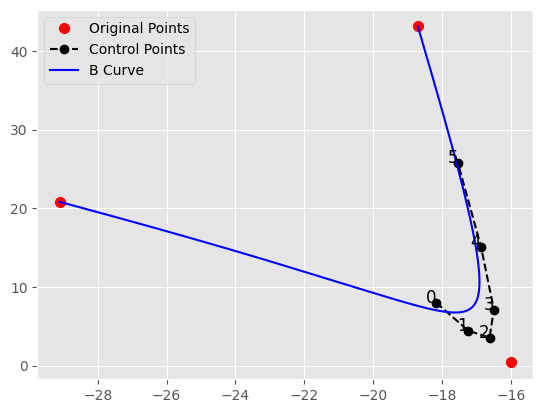

In [14]:
import matplotlib.pyplot as plt
# Plot the original points
plt.plot(xpoints, ypoints, "ro", markersize = 7, label='Original Points')
# Get the Bezier parameters based on a degree.
data = get_bezier_parameters(xpoints, ypoints, 0.7, degree=len(xpoints)*2+1) #BZ0 BZ5 BZ8 BZ11 son los de paso, por tanto habrá 4*2 + 1 puntos de contol ya que el algoritmo te pone 1 pnt cntrl en el 1 punto y en el último

x_val = [x[0] for x in data]
y_val = [x[1] for x in data]
print(data)
print(x_val)
print(y_val)
x_val = np.delete(x_val, 0)
x_val = np.delete(x_val, -1)
y_val = np.delete(y_val, 0)
y_val = np.delete(y_val, -1)
print("Len: ",len(x_val))

# Añadir etiquetas de los índices
for i, (xi, yi) in enumerate(zip(x_val, y_val)):
    plt.text(xi, yi, str(i), fontsize=12, ha='right')


# Plot the control points
plt.plot(x_val,y_val,'k--o', label='Control Points')
# Plot the resulting Bezier curve
xvals, yvals = bezier_curve(data, nTimes=1000)
#plt.xlim(40, 40.5)
#plt.ylim(-3.72725, -3.72580)
plt.plot(xvals, yvals, 'b-', label='B Curve')
plt.legend()
plt.show()

In [15]:
import numpy as np

def xy_to_lonlat_vector(x, y, lon0, lat0):
    """
    Convierte vectores de coordenadas en metros (x, y) a vectores de longitud y latitud
    desde un punto de origen (lon0, lat0).
    
    Parámetros:
    x (array-like): Coordenadas x en metros desde el origen.
    y (array-like): Coordenadas y en metros desde el origen.
    lon0 (float): Longitud del origen en grados.
    lat0 (float): Latitud del origen en grados.
    
    Retorna:
    (numpy.array, numpy.array): Arrays de longitud y latitud en grados.
    """
    # Radio de la Tierra en metros
    R = 6378137.0  

    # Convertir el desplazamiento en latitud
    lat = lat0 + (y / R) * (180 / np.pi)
    
    # Ajustar el radio en función de la latitud para calcular longitud
    lon = lon0 + (x / (R * np.cos(np.radians(lat0)))) * (180 / np.pi)
    
    return lon, lat


In [16]:


latpoints, lonpoints = xy_to_lonlat_vector(xpoints, ypoints, 40.4504131,	-3.7270610)

for i in range(len(xpoints)):
    points.append([latpoints[i],lonpoints[i]])

x_val, y_val = xy_to_lonlat_vector(x_val, y_val, 40.4504131,	-3.7270610)

[[33.3, 12.3], [21.811593891661484, 3.356722324750471], [20.667138742907923, 2.5327937427538583], [18.20816638222612, 6.998977716073369], [14.622939475124658, 17.01119753292817], [11.415068260698364, 29.305657819434096], [10.83996809758945, 38.986665514764866], [14.401249224892622, 42.79042524503622], [21.642147148689535, 41.04383432450821], [35.4, 33.9]]
[33.3, 21.811593891661484, 20.667138742907923, 18.20816638222612, 14.622939475124658, 11.415068260698364, 10.83996809758945, 14.401249224892622, 21.642147148689535, 35.4]
[12.3, 3.356722324750471, 2.5327937427538583, 6.998977716073369, 17.01119753292817, 29.305657819434096, 38.986665514764866, 42.79042524503622, 41.04383432450821, 33.9]
Len:  8


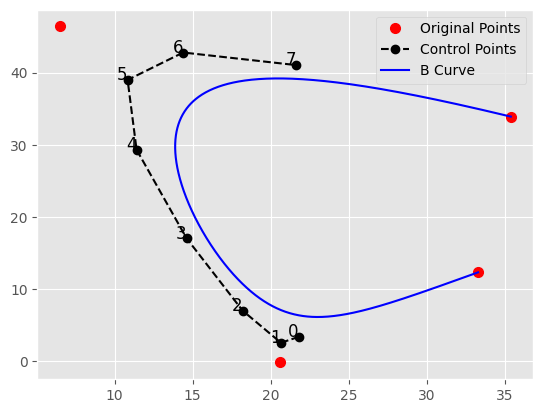

In [17]:
import matplotlib.pyplot as plt
# Plot the original points
plt.plot(xpoints, ypoints, "ro", markersize = 7, label='Original Points')
# Get the Bezier parameters based on a degree.
data = get_bezier_parameters(xpoints, ypoints, 0.7, degree=len(xpoints)*2+1) #BZ0 BZ5 BZ8 BZ11 son los de paso, por tanto habrá 4*2 + 1 puntos de contol ya que el algoritmo te pone 1 pnt cntrl en el 1 punto y en el último

x_val = [x[0] for x in data]
y_val = [x[1] for x in data]
print(data)
print(x_val)
print(y_val)
x_val = np.delete(x_val, 0)
x_val = np.delete(x_val, -1)
y_val = np.delete(y_val, 0)
y_val = np.delete(y_val, -1)
print("Len: ",len(x_val))

# Añadir etiquetas de los índices
for i, (xi, yi) in enumerate(zip(x_val, y_val)):
    plt.text(xi, yi, str(i), fontsize=12, ha='right')


# Plot the control points
plt.plot(x_val,y_val,'k--o', label='Control Points')
# Plot the resulting Bezier curve
xvals, yvals = bezier_curve(data, nTimes=1000)
#plt.xlim(40, 40.5)
#plt.ylim(-3.72725, -3.72580)
plt.plot(xvals, yvals, 'b-', label='B Curve')
plt.legend()
plt.show()

In [18]:
#Ahora que ya tenemos los puntos de paso y de control necesitamos llevarlo a paparazzi en un xml

#Hay que tener en cuenta lo siguiente: Después de BZ0 -> 4 pnts control, luego entre punto y punto habrá 2 de control
Puntos_control = np.array([x_val, y_val]).T
Total_puntos = Puntos_control.shape[0] + Puntos_paso.shape[0]
Puntos_Bezier = np.zeros((Total_puntos, Puntos_control.shape[1]))

#Añadimos en primer lugar BZ0 y los 4 puntos de control

Puntos_Bezier[0] = Puntos_paso[0]
for i in range(1, 5, 1):
    print(i)
    Puntos_Bezier[i] = Puntos_control[i-1]

idx_control = 4
idx_paso = 1

for i in range(5, len(Puntos_Bezier), 3):
    if idx_paso<=len(Puntos_paso)-1:
        print("Paso: ", idx_paso)
        print("Punto añadido: ", Puntos_paso[idx_paso])
        Puntos_Bezier[i] = Puntos_paso[idx_paso]
        idx_paso += 1
    if idx_control<=len(Puntos_control)-1:
        print("Control 1:", idx_control)
        print("Punto añadido: ", Puntos_control[idx_control])
        Puntos_Bezier[i+1] = Puntos_control[idx_control]
        idx_control += 1
    if idx_control<=len(Puntos_control)-1:
        print("Control 2:", idx_control)
        print("Punto añadido: ", Puntos_control[idx_control])
        Puntos_Bezier[i+2] = Puntos_control[idx_control]
        idx_control += 1
    print(Puntos_Bezier)

1
2
3
4
Paso:  1
Punto añadido:  [20.6 -0.2]
Control 1: 4
Punto añadido:  [11.41506826 29.30565782]
Control 2: 5
Punto añadido:  [10.8399681  38.98666551]
[[33.29999924 12.30000019]
 [21.81159389  3.35672232]
 [20.66713874  2.53279374]
 [18.20816638  6.99897772]
 [14.62293948 17.01119753]
 [20.60000038 -0.2       ]
 [11.41506826 29.30565782]
 [10.8399681  38.98666551]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]
Paso:  2
Punto añadido:  [ 6.5 46.4]
Control 1: 6
Punto añadido:  [14.40124922 42.79042525]
Control 2: 7
Punto añadido:  [21.64214715 41.04383432]
[[33.29999924 12.30000019]
 [21.81159389  3.35672232]
 [20.66713874  2.53279374]
 [18.20816638  6.99897772]
 [14.62293948 17.01119753]
 [20.60000038 -0.2       ]
 [11.41506826 29.30565782]
 [10.8399681  38.98666551]
 [ 6.5        46.40000153]
 [14.40124922 42.79042525]
 [21.64214715 41.04383432]
 [ 0.          0.        ]]
Paso:  3
Punto añadido:  [35.4 33.9]
[[33.299999

In [19]:
print("Paso:\n", Puntos_paso)

print("Control:\n", Puntos_control)

print("Bezier:\n", Puntos_Bezier)

Paso:
 [[33.3 12.3]
 [20.6 -0.2]
 [ 6.5 46.4]
 [35.4 33.9]]
Control:
 [[21.81159389  3.35672232]
 [20.66713874  2.53279374]
 [18.20816638  6.99897772]
 [14.62293948 17.01119753]
 [11.41506826 29.30565782]
 [10.8399681  38.98666551]
 [14.40124922 42.79042525]
 [21.64214715 41.04383432]]
Bezier:
 [[33.29999924 12.30000019]
 [21.81159389  3.35672232]
 [20.66713874  2.53279374]
 [18.20816638  6.99897772]
 [14.62293948 17.01119753]
 [20.60000038 -0.2       ]
 [11.41506826 29.30565782]
 [10.8399681  38.98666551]
 [ 6.5        46.40000153]
 [14.40124922 42.79042525]
 [21.64214715 41.04383432]
 [35.40000153 33.90000153]]


In [20]:
Puntos_control

array([[21.81159389,  3.35672232],
       [20.66713874,  2.53279374],
       [18.20816638,  6.99897772],
       [14.62293948, 17.01119753],
       [11.41506826, 29.30565782],
       [10.8399681 , 38.98666551],
       [14.40124922, 42.79042525],
       [21.64214715, 41.04383432]])

In [26]:
# Ahora hay que meter estos puntos en el xml

# Añadimos una columna de ceros donde meteremos los nombres
Columna_nombres = np.zeros(Puntos_Bezier.shape[0], dtype=object)  # Cambiado a un vector de tamaño adecuado

dtype = [('nombre', 'U10'), ('x', 'f4'), ('y', 'f4')]  # U10 para string, f4 para float

# Concatenar la columna de nombres y Puntos_Bezier
resultado = np.empty(len(Columna_nombres), dtype=dtype)  # Crear un array vacío del tipo correcto
resultado['nombre'] = Columna_nombres  # Asignar la columna de nombres
resultado['x'] = Puntos_Bezier[:, 0]  # Asignar la columna x
resultado['y'] = Puntos_Bezier[:, 1]  # Asignar la columna y

unchanged_array = np.zeros(len(unchangedpoints), dtype=dtype)

# Ponemos el nombre en la columna correspondiente
for i in range(len(resultado)):
    resultado[i]['nombre'] = f'BZ{i}'
print(resultado)

# Rellenamos este array
for i, (nombre, x_str, y_str) in enumerate(unchangedpoints):
    unchanged_array[i] = (nombre, float(x_str), float(y_str)) 


[('BZ0', 33.3     , 12.3      ) ('BZ1', 21.811594,  3.3567224)
 ('BZ2', 20.66714 ,  2.5327938) ('BZ3', 18.208166,  6.9989777)
 ('BZ4', 14.622939, 17.011198 ) ('BZ5', 20.6     , -0.2      )
 ('BZ6', 11.415069, 29.305658 ) ('BZ7', 10.839968, 38.986664 )
 ('BZ8',  6.5     , 46.4      ) ('BZ9', 14.401249, 42.790424 )
 ('BZ10', 21.642147, 41.043835 ) ('BZ11', 35.4     , 33.9      )]


In [27]:
#Si se añade para que vaya más de un barco esto habrá que modificarlo para que cree diferentes archivos
# Reescribir todos los waypoints organizados desde 'resultados'

for name, x, y in resultado:
    new_waypoint = ET.Element('waypoint', name=name, x=str(x), y=str(y))
    way_points.append(new_waypoint)
for name, x, y in unchangedpoints:
    new_unchanged = ET.Element('waypoint', name=name, x=str(x), y=str(y))
    way_points.append(new_unchanged)

# Función para formatear el XML
def prettify(element):
    """ Devuelve una versión 'bonita' del XML """
    rough_string = ET.tostring(element, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

# Guardar los cambios en el archivo XML
with open('/home/dacya-iagesbloom/Documents/paparazzi/conf/flight_plans/UCM/PRUEBA_BZ_V4_optimizado.xml', 'w', encoding='utf-8') as f:
    f.write('<!DOCTYPE flight_plan SYSTEM "../flight_plan.dtd">\n')
    f.write(prettify(root))

print("Waypoints reescritos y guardados")

Waypoints reescritos y guardados


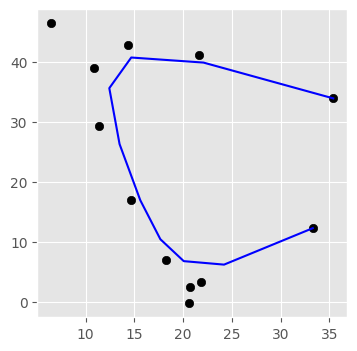

In [28]:
import numpy as np
import matplotlib.pyplot as plt

x = Puntos_Bezier[:, 0]
y = Puntos_Bezier[:, 1]
#x = np.concatenate((Puntos_control[:, 0], Puntos_paso[:, 0]))
#y = np.concatenate((Puntos_control[:, 1], Puntos_paso[:, 1]))
#z = np.random.random_sample((3,))

CELLS = 10
nCPTS = np.size(x, 0)
n = nCPTS - 1 # numero total de segmentos
i = 0
t = np.linspace(0, 1, CELLS) # VARIABLE PARAMETRICA
B = []

xBezier = np.zeros((1, CELLS))
yBezier = np.zeros((1, CELLS))
#zBezier = np.zeros((1, CELLS))

def Ni(n, i):
    return np.math.factorial(n) / (np.math.factorial(i) * np.math.factorial(n - i))

def basisFunction(n, i, t):
    J = np.array(Ni(n, i) * (t ** i) * (1 - t) ** (n - i))
    return J

for k in range(0, nCPTS):
    B.append(basisFunction(n, i, t))

    xBezier = basisFunction(n, i, t) * x[k] + xBezier
    yBezier = basisFunction(n, i, t) * y[k] + yBezier
    #zBezier = basisFunction(n, i, t) * z[k] + zBezier

    i += 1

'''for line in B:
    plt.plot(t, line)'''

fig1 = plt.figure(figsize=(4, 4))
ax1 = fig1.add_subplot(111)
ax1.scatter(x, y, c='black')
ax1.plot(xBezier[0], yBezier[0], c='blue')

plt.show()

In [22]:
x

array([40.45075226, 32.88956859, 36.61621596, 39.2188458 , 40.5188077 ,
       40.45091629, 40.8678261 , 40.79348768, 40.45085526, 40.6475169 ,
       40.54575625, 40.45094299])

In [23]:
Puntos_Bezier

array([[40.45075226, -3.727175  ],
       [32.88956859, -3.03051075],
       [36.61621596, -3.37389937],
       [39.2188458 , -3.61369743],
       [40.5188077 , -3.73344232],
       [40.45091629, -3.72725105],
       [40.8678261 , -3.76555482],
       [40.79348768, -3.75866609],
       [40.45085526, -3.7270689 ],
       [40.6475169 , -3.74519693],
       [40.54575625, -3.73582049],
       [40.45094299, -3.7270999 ]])

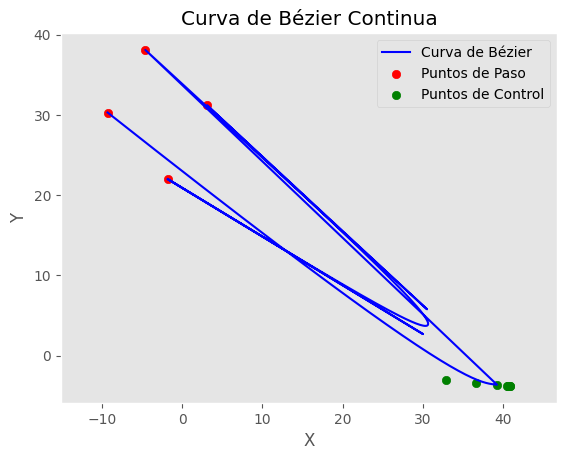

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Definición de puntos de paso y puntos de control
Puntos_paso = np.array([[-9.3, 30.3], [-4.6, 38.1], [3.1, 31.2], [-1.8, 22.]], dtype=np.float32)
Puntos_control = Puntos_control

# Función para calcular la curva de Bézier
def bezier_curve(P0, P1, P2, P3, t):
    return (1-t)[:, np.newaxis]**3 * P0 + 3 * (1-t)[:, np.newaxis]**2 * t[:, np.newaxis] * P1 + 3 * (1-t)[:, np.newaxis] * t[:, np.newaxis]**2 * P2 + t[:, np.newaxis]**3 * P3

# Crear un array para almacenar la curva completa
curva_completa = np.empty((0, 2))

# Primer segmento (con 4 puntos de control)
P0 = Puntos_paso[0]
P1, P2, P3, P4 = Puntos_control[0:4]
t = np.linspace(0, 1, 100)
curva = bezier_curve(P0, P1, P2, P3, t)  # BZ0 a BZ5 con 4 puntos de control
curva_completa = np.vstack((curva_completa, curva))

# Segmentar las curvas para los siguientes puntos de paso (con 2 puntos de control por cada paso)
for i in range(1, len(Puntos_paso) - 1):
    P0 = Puntos_paso[i]
    P1, P2 = Puntos_control[2*(i-1) + 4: 2*(i-1) + 6]  # Dos puntos de control por cada paso
    t = np.linspace(0, 1, 100)
    curva = bezier_curve(P0, P1, P2, Puntos_paso[i+1], t)  # Calcula la curva para el siguiente paso
    curva_completa = np.vstack((curva_completa, curva))

# Manejar el último segmento (último punto de paso)
P0 = Puntos_paso[-1]
P1, P2 = Puntos_control[-2:]  # Últimos 2 puntos de control
curva = bezier_curve(P0, P1, P2, P0, t)  # Último segmento (sin siguiente paso)
curva_completa = np.vstack((curva_completa, curva))

# Graficar la curva completa
plt.figure()
plt.plot(curva_completa[:, 0], curva_completa[:, 1], c='blue', label='Curva de Bézier')

# Graficar los puntos de paso
plt.scatter(Puntos_paso[:, 0], Puntos_paso[:, 1], color='red', label='Puntos de Paso')

# Graficar los puntos de control
plt.scatter(Puntos_control[:, 0], Puntos_control[:, 1], color='green', label='Puntos de Control')

plt.legend()
plt.title('Curva de Bézier Continua')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.axis('equal')
plt.show()


In [25]:
Puntos_paso


array([[-9.3, 30.3],
       [-4.6, 38.1],
       [ 3.1, 31.2],
       [-1.8, 22. ]], dtype=float32)

In [26]:
Puntos_control

array([[32.88956859, -3.03051075],
       [36.61621596, -3.37389937],
       [39.2188458 , -3.61369743],
       [40.5188077 , -3.73344232],
       [40.8678261 , -3.76555482],
       [40.79348768, -3.75866609],
       [40.6475169 , -3.74519693],
       [40.54575625, -3.73582049]])